## Imports

In [1]:
%matplotlib inline

import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pylab as plt

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
import time

from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC

## Lesson functions

In the lesson_functions, contain all the functions defined during the lesson of the Udacity class.
  * get_hog_features()
  * bin_spatial()
  * color_hist()
  * extract_features()
  * slide_window()
  * draw_boxes()

# Debug Class

In [2]:
class Debug():
    def __init__(self, 
                 my_debug_write = False, 
                 my_debug_plot = False,                  
                 my_image_output_folder='test_images_output/',
                 my_image_filename_post='',    
                ):
        
        self.debug_write = my_debug_write;  
        self.debug_plot = my_debug_plot; 
        self.image_output_folder = my_image_output_folder;
        self.image_filename_post = my_image_filename_post; # post_filename for image_output
        
        if not os.path.exists(self.image_output_folder):
            os.makedirs(self.image_output_folder)
        
    def my_debug_out(self, img, shortname, is_gray=False):
        if (self.debug_plot): # Plot Image on screen
            plt.figure()
            if(is_gray == True):
                plt.imshow(img, cmap='gray')
            else:
                plt.imshow(img)
            plt.title(shortname, fontsize=25)
            
        # Write image to output_folder
        if (self.debug_write):
            if (is_gray == False):
                cv2.imwrite(self.image_output_folder  + shortname + self.image_filename_post + '.jpg', img)
            else:
                cv2.imwrite(self.image_output_folder  + shortname + self.image_filename_post + '.jpg', img)
                
    def my_histogram_out(self, hist, bin_centers, shortname):
        return
        
        fig = plt.figure()
        plt.bar(bin_centers, hist[0], width=2)
        plt.xlim(0, 256)
        plt.title(shortname)
            
        # Write image to output_folder
        if (self.debug_write):
            plt.savefig(self.image_output_folder  + shortname + self.image_filename_post + '.jpg')

        if (self.debug_plot == False): # Plot Image on screen
            plt.close(fig)
                
    


## Feature Extractor Class

In [12]:
class FeatureExtractor():
    def __init__(self, debug):
        
        self.my_debug = debug
        self.color_space = 'RGB'
        self.spatial_size= (32, 32)
        self.hist_bins=32
        self.orient=9
        self.pix_per_cell=8
        self.cell_per_block=2
        self.hog_channel=0
        self.transform_sqrt=False
        self.spatial_feat=True
        self.hist_feat=True
        self.hog_feat=True
        
        
    # Define a function to return HOG features and visualization
    def get_hog_features(self, img, visualize = False, feature_vector=True):
        # Call with two outputs if vis==True
       
        if (visualize):
            features, hog_image = hog(img, orientations=self.orient, 
                                      pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                                      cells_per_block=(self.cell_per_block, self.cell_per_block), 
                                      transform_sqrt=self.transform_sqrt, 
                                      visualise=visualize, feature_vector=feature_vector)
            return features, hog_image
        else:
            features = hog(img, orientations=self.orient, 
                            pixels_per_cell=(self.pix_per_cell, self.pix_per_cell),
                            cells_per_block=(self.cell_per_block, self.cell_per_block), 
                            transform_sqrt=self.transform_sqrt, 
                            visualise=visualize, feature_vector=feature_vector)
            return features
        

    # Define a function to compute binned color features  
    def bin_spatial(self, img):
        # Use cv2.resize().ravel() to create the feature vector
        bin_spatial_img = cv2.resize(img, self.spatial_size)
        features = bin_spatial_img.ravel()
        # Return the feature vector
        return features, bin_spatial_img

    # Define a function to compute color histogram features 
    # NEED TO CHANGE bins_range if reading .png files with mpimg!
    def color_hist(self, img):
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=self.hist_bins, range=(0, 256))
        channel2_hist = np.histogram(img[:,:,1], bins=self.hist_bins, range=(0, 256))
        channel3_hist = np.histogram(img[:,:,2], bins=self.hist_bins, range=(0, 256))
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

        # Generating bin centers
        bin_edges = channel1_hist[1]
        bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2

        return hist_features, channel1_hist, channel2_hist, channel3_hist, bin_centers
    
    def convert_color(self, img):
        if self.color_space == 'RGB':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        elif self.color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        elif self.color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
        elif self.color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
        elif self.color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        elif self.color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
        return feature_image
    
    
    # Define a function to extract features from a single image window
    # This function is very similar to extract_features()
    # just for a single image rather than list of images
    def single_img_features(self, img):    
        
        self.my_debug.my_debug_out(img, shortname='01_input_img', is_gray=False)
        
        #1) Define an empty list to receive features
        img_features = []
        #2) Apply color conversion 
        feature_image = self.convert_color(img)
            
        #3) Compute spatial features if flag is set
        if self.spatial_feat == True:
            spatial_features, bin_spatial_img = self.bin_spatial(feature_image)
            self.my_debug.my_debug_out(bin_spatial_img, shortname='02_bin_spatial_img', is_gray=False)
            #4) Append features to list
            img_features.append(spatial_features)
            
        #5) Compute histogram features if flag is set
        if self.hist_feat == True:
            hist_features, ch1_hist, ch2_hist, ch3_hist, bin_centers = self.color_hist(feature_image)
            
            self.my_debug.my_histogram_out(ch1_hist, bin_centers, "03_ch1_hist")
            self.my_debug.my_histogram_out(ch2_hist, bin_centers, "03_ch2_hist")
            self.my_debug.my_histogram_out(ch3_hist, bin_centers, "03_ch3_hist")
            #6) Append features to list
            img_features.append(hist_features)
            
        #7) Compute HOG features if flag is set
        if self.hog_feat == True:
            if self.hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    ch_features, hog_image_float  = self.get_hog_features(feature_image[:,:,channel], visualize=True, 
                                                                          feature_vector=True)
                    self.my_debug.my_debug_out(hog_image_float*255, shortname='04_hog_image'+ channel, is_gray=True)   
                    hog_features.extend(ch_features)      
            else:
                hog_features, hog_image_float = self.get_hog_features(feature_image[:,:,self.hog_channel], visualize=True, 
                                                                      feature_vector=True)
                self.my_debug.my_debug_out(hog_image_float*255, shortname='04_hog_image', is_gray=True)   
                
            #8) Append features to list
            img_features.append(hog_features)


        #9) Return concatenated array of features
        return np.concatenate(img_features)
    
    def extract_features(self, imgs):
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        for file in imgs:
            file_features = []
            
            # Save filename in order to save files
            self.my_debug.image_filename_post = '_' + os.path.splitext(os.path.basename(file))[0]
            
            # Read in each one by one
            image_in = cv2.imread(file) # read BGR
            
            file_features = self.single_img_features(image_in)   
            
            features.append(file_features)
        # Return list of feature vectors
        return features


    def normalize_features(self, img_features):
        X = np.vstack(img_features).astype(np.float64)                        
        # Fit a per-column scaler
        X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = X_scaler.transform(X)
        
        return scaled_X, X_scaler
    
    # Define a single function that can extract features using hog sub-sampling and make predictions
    def find_cars(self, img, ystart, ystop, scale, svc, X_scaler):
        draw_img = np.copy(img)

        img = img[ystart:ystop,:,:]

        ctrans_tosearch = self.convert_color( img)

        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
       # ch2 = ctrans_tosearch[:,:,1]
       # ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // self.pix_per_cell) - self.cell_per_block + 1
        nyblocks = (ch1.shape[0] // self.pix_per_cell) - self.cell_per_block + 1 
        nfeat_per_block = self.orient*self.cell_per_block**2

        print('nxblocks: ' + str(nxblocks))
        print('nyblocks: ' + str(nyblocks))

        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // self.pix_per_cell) - self.cell_per_block + 1
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = self.get_hog_features(ch1, visualize=False, feature_vector=False)
       # hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
       # hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                #hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                #hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1))#, hog_feat2, hog_feat3))

                xleft = xpos*self.pix_per_cell
                ytop = ypos*self.pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features

                spatial_features, _ = self.bin_spatial(subimg)
                hist_features, _, _, _, _   = self.color_hist(subimg)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
                #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)

                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 

        return draw_img

# Train Classifier

In [13]:
##### DATA PREPARATION #### 

my_debug = Debug(my_debug_write = False,
                 my_debug_plot = False,                  
                 my_image_output_folder='test_images_output/')

car_dirs = ["data/vehicles/KITTI_extracted/", "data/vehicles/GTI_Far/", "data/vehicles/GTI_Left/", 
            "data/vehicles/GTI_MiddleClose/", "data/vehicles/GTI_Right/"]
notcar_dirs = ["data/non-vehicles/GTI/", "data/non-vehicles/Extras/"]


car_images = []
for my_dir in car_dirs:
    car_images.extend(glob.glob(my_dir+'*.png'))

notcar_images = []
for my_dir in notcar_dirs:
    notcar_images.extend(glob.glob(my_dir+'*.png') ) 

# Shuffle the data within the image arrays
random.shuffle(car_images)
random.shuffle(notcar_images)

print('car_images length:', len(car_images))
print('notcar_images length:', len(notcar_images))

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 10
car_images = car_images[0:sample_size]
notcar_images = notcar_images[0:sample_size]
    
    
###### FEATURE EXTRACTION #######
my_feature_extractor = FeatureExtractor(debug = my_debug) 

car_features = my_feature_extractor.extract_features(car_images)
notcar_features = my_feature_extractor.extract_features(notcar_images)

feature_list = [car_features, notcar_features] 

scaled_X, X_scaler = my_feature_extractor.normalize_features(feature_list)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)


print('Feature vector length:', len(X_train[0]))

###### TRAIN CLASSIFIER #######
# Use a linear SVC 
svc = LinearSVC(verbose=True)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


car_images length: 8792
notcar_images length: 8968
Feature vector length: 4932
[LibLinear]0.01 Seconds to train SVC...
Test Accuracy of SVC =  0.75


# Test Images

nxblocks: 159
nyblocks: 31


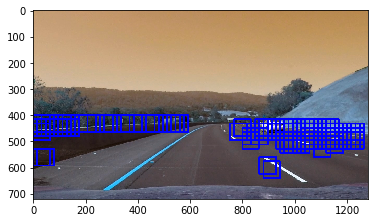

In [15]:
#### Uncomment if only testing one image


my_debug = Debug(my_debug_write = False,
                 my_debug_plot = False,                  
                 my_image_output_folder='test_images_output/')
my_feature_extractor = FeatureExtractor(debug = my_debug) 


test_images_dir = "test_images/"
test_images = glob.glob(test_images_dir+'*.jpg')  

# uncomment
test_images = ['test_images/test3.jpg']  
    
for image_to_read in test_images:
    image_in = cv2.imread(image_to_read)
    #draw_image = np.copy(image_in)
    
    ystart = 400
    ystop = 656
    scale = 1
    
    out_img = my_feature_extractor.find_cars(image_in, ystart, ystop, scale, svc, X_scaler)
    plt.imshow(out_img)
    
    
   # windows = slide_window(image_in, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                  #      xy_window=(96, 96), xy_overlap=(0.5, 0.5))

    
   # hot_windows = search_windows(my_feature_extractor, image_in, windows, svc, X_scaler)                       

   # window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

   # plt.imshow(window_img)

# Test Videos

In [ ]:
if not os.path.exists('test_videos_output'):
    os.makedirs('test_videos_output')
    
my_lane_detector = LaneDetector()

white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/project_video.mp4")
white_clip = clip1.fl_image(my_lane_detector.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

In [ ]:
print(test_images_dir+'?.jpg')

In [ ]:
print(y)

In [ ]:
a = glob.glob(test_images_dir+'*.png')

In [ ]:
print(feature_list)

In [ ]:
a.append(1)

In [ ]:
a

In [ ]:
feature_list

In [ ]:
notcar_images

In [ ]:
class VehicleDetector():
    def __init__(self, 
                 my_debug_write = False, 
                 my_debug_plot = False,                  
                 my_image_output_folder='test_images_output/',
                 my_image_filename_post='',
                 my_smooth_factor=5,
                 my_ym_per_pix=30/720,
                 my_xm_per_pix=3.7/700           
                ):
        
        self.debug_write = my_debug_write;  
        self.debug_plot = my_debug_plot; 
        self.image_output_folder = my_image_output_folder;
        self.image_filename_post = my_image_filename_post; # post_filename for image_output
        self.smooth_factor = my_smooth_factor

        self.ym_per_pix = my_ym_per_pix # meters per pixel in y dimension
        self.xm_per_pix = my_xm_per_pix # meters per pixel in x dimension

        self.recent_left_fits = []
        self.recent_right_fits = []
            
        self.left_fits = []
        self.right_fits = []
        
        self.recent_detected_left = False;
        self.recent_detected_right = False;
        
    def my_debug_out(self, img, shortname, is_gray=False):
        
        if (self.debug_plot): # Plot Image on screen
            plt.figure()
            if(is_gray == True):
                plt.imshow(img, cmap='gray')
            else:
                plt.imshow(img)
            plt.title(shortname, fontsize=25)
            
        # Write image to output_folder
        if (self.debug_write):
            if (is_gray == False):
                cv2.imwrite(self.image_output_folder  + shortname + self.image_filename_post + '.jpg', img)
            else:
                cv2.imwrite(self.image_output_folder  + shortname + self.image_filename_post + '.jpg', img)
        
    def print_histogram(self, histogram, title):
        if (self.debug_plot): # Plot Image on screen
            plt.figure()
            plt.plot(histogram)
            plt.title('Histogram', fontsize=25)
    
    
    def process_image(self, image_in):
        
        self.my_debug_out(image_in, shortname='01_image_in', is_gray=False)
        
        
        ####### HOG ########
        gray = cv2.cvtColor(image_in, cv2.COLOR_BGR2GRAY)
        self.my_debug_out(gray, shortname='02_image_gray', is_gray=True)
        
        orient = 9
        pix_per_cell = 8
        cell_per_block = 2
        # Call our function with vis=True to see an image output
        features, hog_image_float = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    
        self.my_debug_out(hog_image_float*255, shortname='02_hog_image', is_gray=True)
        
        ####### Color Features ########
        gray = cv2.cvtColor(image_in, cv2.COLOR_BGR2GRAY)
        self.my_debug_out(gray, shortname='02_image_gray', is_gray=True)
        
        orient = 9
        pix_per_cell = 8
        cell_per_block = 2
        # Call our function with vis=True to see an image output
        features, hog_image_float = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
    
        self.my_debug_out(hog_image_float*255, shortname='02_hog_image', is_gray=True)
        

        return hog_image_float